In [1]:
import sys
sys.path.append('../../../pywholebrain')
import pandas as pd
import numpy as np
import wholeBrainClassify as wbc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import precision_score, recall_score



Error importing wholeBrainClassify.py
	 ERROR :  cannot import name 'sortNoise'


In [2]:
classMetricsPath = '/home/ackmanadmin/Documents/classifier/p21_classifier_metrics.tsv'

domain_vars = [
             #spatial metrics
             'spatial.min', 'spatial.max', 
             'threshold.area', #'mass.perc','threshold.perc', 'mass.region', #choose 1 
             #'spatial.COMdom.x', 'spatial.COMdom.y', #positional argument - do we need?
             'region.extent', 
             'region.minaxis', 'region.majaxis',
             'region.eccentricity', #'region.majmin.ratio',  #choose 1

             #temporal metrics
             'freq.rangesz', #'length', #choose 1
             'temporal.max', 'temporal.std',  #'temporal.autocorr', 
             'freq.range.low', 'freq.range.high']

nodomain_vars =[
    'spatial.min',
    'spatial.max',
    'spatial.COMdom.x',
    'spatial.COMdom.y',
    'freq.maxsnr',
    'spatial.COMall.x',
#   'freq.avgsnr',
    'spatial.std',
    'temporal.max',
    'temporal.autocorr',
    'freq.range.low',
    'temporal.std',
    'temporal.min'
#   'signal_index',
#   'spatial.COMall.y'
#   'freq.integrate',
#   'freq.range.high',
#   'freq.rangesz',
#   'spatial.avg'
]


try:
    main_data = pd.DataFrame.from_csv(classMetricsPath, sep = '\t', index_col='exp_ic')
    print('Importing dataframe\n------------------------------------')
    print(main_data.head())
except Exception as e:
    main_data = pd.DataFrame()
    print('Error importing dataFrame')
    print('\t ERROR : ', e)
    assert not main_data.empty, 'Check path to metrics dataframe'
    
# main_data -= main_data.min()
# main_data /= main_data.max()
# main_data.to_csv(classMetricsPath, sep = '\t')

domain = main_data.loc[main_data['threshold.area'] != 0].copy()
nodomain = main_data.loc[main_data['threshold.area'] == 0].copy()
print(main_data.head())

Importing dataframe
------------------------------------
                 age  artifact  freq.avgsnr  freq.integrate  freq.maxsnr  \
exp_ic                                                                     
170804_02-0000  21.0       1.0     0.052324        0.016939     0.041221   
170804_02-0001  21.0       1.0     0.038568        0.005700     0.033920   
170804_02-0002  21.0       1.0     0.025418        0.005296     0.019019   
170804_02-0003  21.0       0.0     0.033792        0.008608     0.023504   
170804_02-0004  21.0       0.0     0.023912        0.006612     0.018618   

                freq.maxsnr.freq  freq.range.high  freq.range.low  \
exp_ic                                                              
170804_02-0000          0.102564         0.499511        0.209382   
170804_02-0001          0.102564         0.544809        0.271851   
170804_02-0002          0.076923         0.457973        0.161212   
170804_02-0003          0.076923         0.544809        0.352864

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:41: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


In [3]:
score = []
precision = []
recall = []
signal = []
artifact = []

truep =[]
truen =[]
falsep = []
falsen = []
for i in range(1000):
    X_train, X_test, y_train, y_test = wbc.splitData(domain.loc[:,domain_vars].copy(), domain.loc[:,'signal'].copy())
    X2_train, X2_test, y2_train, y2_test = wbc.splitData(nodomain.loc[:,nodomain_vars].copy(), nodomain.loc[:,'signal'].copy())

    Xlen = len(domain)
    X2len = len(nodomain)

    Xfraction = Xlen / (Xlen + X2len)
    X2fraction = X2len / (Xlen + X2len) 

    rnd_clf = RandomForestClassifier(n_estimators = 40, max_features = 2)
    rnd_clf.fit(X_train, y_train)
    y_pred = rnd_clf.predict(X_test)
    y_pred_2 = rnd_clf.predict(X_train)
    
    rnd_score = rnd_clf.score(X_test, y_test)
    rnd_precision =  precision_score(y_test, y_pred)
    rnd_recall = recall_score(y_test, y_pred)
    rnd_signal = (np.sum(((y_pred==1) & (y_test==1))))/(np.sum((y_test==1)))
    rnd_artifact = (np.sum(((y_pred==0) & (y_test==0))))/(np.sum(y_test==0))

    rnd_clf2 = RandomForestClassifier(n_estimators = 40, max_features = 2)
    rnd_clf2.fit(X2_train, y2_train)
    y2_pred = rnd_clf2.predict(X2_test)
    y2_pred_2 = rnd_clf.predict(X2_train)

    truep.append(np.sum(y_pred[y_test==1]==y_test[y_test==1]) + np.sum(y2_pred[y2_test==1]==y2_test[y2_test==1])+
                np.sum(y_pred_2[y_train==1]==y_train[y_train==1]) + np.sum(y2_pred_2[y2_train==1]==y2_train[y2_train==1]))
    truen.append(np.sum(y_pred[y_test==0]==y_test[y_test==0]) + np.sum(y2_pred[y2_test==0]==y2_test[y2_test==0])+
                np.sum(y_pred_2[y_train==0]==y_train[y_train==0]) + np.sum(y2_pred_2[y2_train==0]==y2_train[y2_train==0]))
    falsep.append(np.sum(y_pred[y_test==1]!=y_test[y_test==1]) + np.sum(y2_pred[y2_test==1]!=y2_test[y2_test==1])+
                np.sum(y_pred_2[y_train==1]!=y_train[y_train==1]) + np.sum(y2_pred_2[y2_train==1]!=y2_train[y2_train==1]))
    falsen.append(np.sum(y_pred[y_test==0]!=y_test[y_test==0]) + np.sum(y2_pred[y2_test==0]!=y2_test[y2_test==0])+
                np.sum(y_pred_2[y_train==0]!=y_train[y_train==0]) + np.sum(y2_pred_2[y2_train==0]!=y2_train[y2_train==0]))
    
    rnd_score2 = rnd_clf2.score(X2_test, y2_test)
    rnd_precision2 =  precision_score(y2_test, y2_pred)
    rnd_recall2 = recall_score(y2_test, y2_pred)
    rnd_signal2 = (np.sum(((y2_pred==1) & (y2_test==1))))/(np.sum((y2_test==1)))
    rnd_artifact2 = (np.sum(((y2_pred==0) & (y2_test==0))))/(np.sum(y2_test==0))

    score.append((Xfraction * rnd_score) + (X2fraction * rnd_score2))
    precision.append((Xfraction * rnd_precision) + (X2fraction * rnd_precision2))
    recall.append((Xfraction * rnd_recall) + (X2fraction * rnd_recall2))


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


1504.135
423.666
78.865
20.334


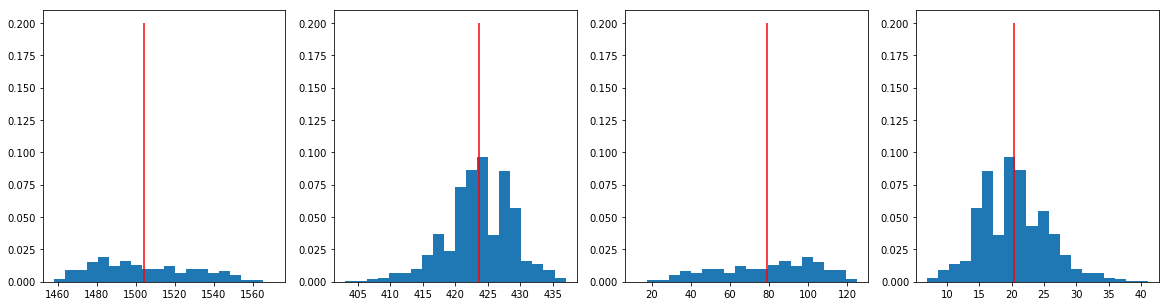

Accuracy of artifact: 
0.9542027027027027
0.0457972972972973
Accuracy of neural: 
0.9501800379027163
0.049819962097283635


In [4]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,4, figsize = (20, 5))

axs[0].hist(truep, bins = 20, normed = True)
axs[0].vlines(np.mean(truep), ymin= 0, ymax = 0.2, color='red')
print(np.mean(truep))
axs[1].hist(truen, bins = 20, normed = True)
axs[1].vlines(np.mean(truen), ymin= 0, ymax = .2, color='red')
print(np.mean(truen))
axs[2].hist(falsep, bins = 20, normed = True)
axs[2].vlines(np.mean(falsep), ymin= 0, ymax = .2, color='red')
print(np.mean(falsep))
axs[3].hist(falsen, bins = 20, normed = True)
axs[3].vlines(np.mean(falsen), ymin= 0, ymax = .2, color='red')
print(np.mean(falsen))

plt.show()

print('Accuracy of artifact: ')
print(np.mean(truen)/(np.mean(truen)+np.mean(falsen)))
print(np.mean(falsen)/(np.mean(truen)+np.mean(falsen)))

print('Accuracy of neural: ')
print(np.mean(truep)/(np.mean(truep)+np.mean(falsep)))
print(np.mean(falsep)/(np.mean(truep)+np.mean(falsep)))

In [5]:
explist = ['190508_05', '190423_01', '190423_05', '190506_01', '190508_01']
false_neg =  [0,  2,  6,  0,  2]
false_pos =  [7,  7,  6,  2,  7]
true_neg =   [62, 59, 70, 65, 44] 
true_pos =   [197,163,182,186,230]
# Different Classifications: 13/266
# Different Classifications: 9/247
# Different Classifications: 25/274
# Different Classifications: 6/253
# Different Classifications: 17/283
# Different Classifications: 27/271


In [6]:
def precisionfxn(true_pos, false_pos):
    return true_pos / (true_pos + false_pos)

def recallfxn(true_pos, false_neg):
    return true_pos / (true_pos + false_neg)

def accuracyfxn(true_pos, false_pos, true_neg, false_neg):
    return (true_pos + true_neg) / (true_pos + true_neg + false_neg + false_pos)

prec = []
reca = []
accu = []
for i, exp in enumerate(explist):
    prec.append(precisionfxn(true_pos[i], false_pos[i]))
    reca.append(recallfxn(true_pos[i], false_neg[i]))
    accu.append(accuracyfxn(true_pos[i], false_pos[i], true_neg[i], false_neg[i]))
    print(exp, ' : Precision ', prec[-1], '\tRecall ' , reca[-1], '\tAccuracy ', accu[-1])

    

190508_05  : Precision  0.9656862745098039 	Recall  1.0 	Accuracy  0.9736842105263158
190423_01  : Precision  0.9588235294117647 	Recall  0.9878787878787879 	Accuracy  0.961038961038961
190423_05  : Precision  0.9680851063829787 	Recall  0.9680851063829787 	Accuracy  0.9545454545454546
190506_01  : Precision  0.9893617021276596 	Recall  1.0 	Accuracy  0.9920948616600791
190508_01  : Precision  0.9704641350210971 	Recall  0.9913793103448276 	Accuracy  0.9681978798586572


/usr/local/lib/python3.5/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


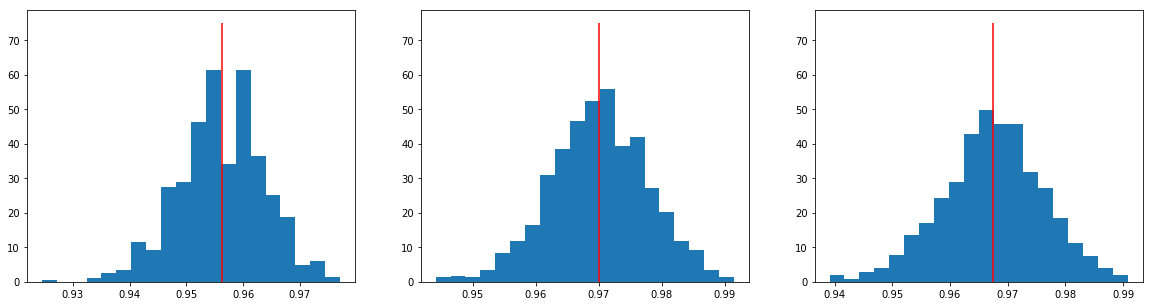

In [15]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize = (20, 5))

axs[0].hist(score, bins = 20, normed = True)
axs[0].vlines(np.mean(score), ymin= 0, ymax = 75, color='red')

axs[1].hist(precision, bins = 20, normed = True)
axs[1].vlines(np.mean(precision), ymin= 0, ymax = 75, color='red')

axs[2].hist(recall, bins = 20, normed = True)
axs[2].vlines(np.mean(recall), ymin= 0, ymax = 75, color='red')

plt.show()

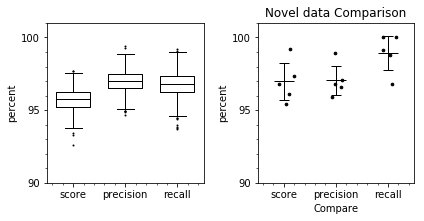

Accuracy mean:  0.9699122735258936
Precision mean:  0.9704841494906609
Recall mean:  0.9894686409213188


In [51]:
data1 = [np.array(score)*100, np.array(precision)*100, np.array(recall)*100]
data2 = [np.array(accu)*100, np.array(prec)*100, np.array(reca)*100]

boxplotprops = {'boxprops':dict(linewidth=1, color='k'), 
    'medianprops':dict(linewidth=1, color='k'), 
    'whiskerprops':dict(linestyle='-', color='k'), 
    'capprops':dict(color='k'),
   'flierprops':dict(markerfacecolor='k', marker='.', linewidth=0.5, markersize = 2)
    }

import matplotlib
colors = matplotlib.cm.get_cmap('tab20c')
import numpy as np

current_class = [96, 97, 96]
fig1, ax = plt.subplots(1, 2, figsize=(6,3))

ax[0].boxplot(data1, widths = 0.65, **boxplotprops)# flierprops=flier)#, boxprops=boxprops, medianprops=medianprops, notch=False, widths=0.75)
ax[0].set_ylim([90, 101])
ax[0].set_xticklabels(['score', 'precision', 'recall'])
ax[0].set_yticks([90, 95, 100])
ax[0].set_ylabel('percent')
ax[0].minorticks_on()

ax[1].errorbar([1,2,3], [np.mean(accu)*100, np.mean(prec)*100, np.mean(reca)*100], yerr =[np.std(accu)*100, np.std(prec)*100, np.std(reca)*100],
           linestyle='', marker='_', markersize = 20,markeredgecolor='k',
           ecolor = 'k', elinewidth = 1, capsize=5)
ax[1].set_ylabel('percent')
ax[1].set_yticks([90, 95, 100])
ax[1].set_xticks([1, 2, 3])
ax[1].set_xticklabels(['score', 'precision', 'recall'])

ax[1].scatter(np.ones(len(accu))*0.9+np.random.random(len(accu))*0.3, np.array(accu)*100, c = 'k', s = 7)
ax[1].scatter(np.ones(len(accu))*1.9+np.random.random(len(accu))*0.3, np.array(prec)*100, c = 'k', s = 7)
ax[1].scatter(np.ones(len(accu))*2.9+np.random.random(len(accu))*0.3, np.array(reca)*100, c = 'k', s = 7)
ax[1].set_ylim([90, 101])
ax[1].set_xlim([0.5,3.5])
ax[1].set_xlabel('Compare')
plt.tight_layout()
ax[1].minorticks_on()
plt.title('Novel data Comparison')
plt.savefig('Novel_data_comparison.svg')
plt.show()


print('Accuracy mean: ', np.mean(accu))
print('Precision mean: ', np.mean(prec))
print('Recall mean: ', np.mean(reca))

7
           n_components  n_signal  n_artifact  perc_signal  perc_artifact
170804_02         207.0     172.0        35.0     0.830918       0.169082
171003_05         255.0     213.0        42.0     0.835294       0.164706
190408_01         233.0     177.0        56.0     0.759657       0.240343
190408_05         243.0     191.0        52.0     0.786008       0.213992
190514_01         303.0     220.0        83.0     0.726073       0.273927
190603_01         301.0     235.0        66.0     0.780731       0.219269
190603_09         232.0     179.0        53.0     0.771552       0.228448
           n_components  n_signal  n_artifact  perc_signal  perc_artifact
190423_01         247.0     170.0        77.0     0.688259       0.311741
190423_05         274.0     190.0        84.0     0.693431       0.306569
190506_01         253.0     187.0        66.0     0.739130       0.260870
190506_05         271.0     211.0        60.0     0.778598       0.221402
190508_01         283.0     225.0   

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:53: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


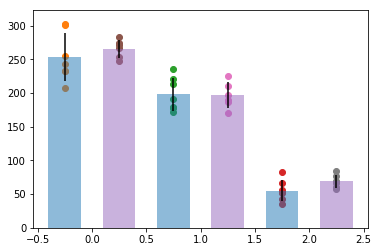

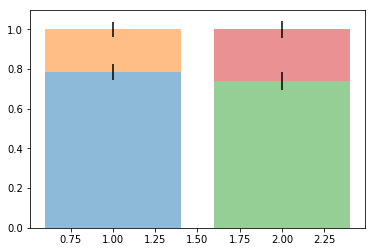

In [42]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


explist = ['170804_02_ica_metrics.tsv',
            '171003_05_ica_metrics.tsv',
            '190408_01_ica_metrics.tsv',
            '190408_05_ica_metrics.tsv',
            '190506_05_ica_metrics.tsv',
            '190514_01_ica_metrics.tsv',
            '190603_01_600components_ica_metrics.tsv',
            '190603_09_600components_ica_metrics.tsv']

novellist = ['190423_01_600components_ica_metrics.tsv',
             '190423_05_600components_ica_metrics.tsv',
             '190506_01_ica_metrics.tsv',
             '190508_01_ica_metrics.tsv',
             '190508_05_ica_metrics.tsv']


print(len(explist))

expdir = '/home/ackmanadmin/Documents/classifier/expMetrics/'

n_components = []
n_signal = []
n_artifact = []

prop = pd.DataFrame()

for i, exp in enumerate(explist):
        data = pd.DataFrame.from_csv(expdir + exp, sep = '\t', index_col='exp_ic')
        prop.loc[exp[:9], 'n_components'] = len(data)
        prop.loc[exp[:9], 'n_signal'] = np.sum(data['signal'])
        prop.loc[exp[:9], 'n_artifact'] = np.sum(data['artifact'])

prop['perc_signal'] = prop['n_signal']/prop['n_components']
prop['perc_artifact'] = prop['n_artifact']/prop['n_components']

print(prop)

expdir = '/home/ackmanadmin/Documents/classifier/expMetrics/'

n_components = []
n_signal = []
n_artifact = []

propn = pd.DataFrame()

for i, exp in enumerate(novellist):
        data = pd.DataFrame.from_csv(expdir + exp, sep = '\t', index_col='exp_ic')
        propn.loc[exp[:9], 'n_components'] = len(data)
        propn.loc[exp[:9], 'n_signal'] = np.sum(data['signal'])
        propn.loc[exp[:9], 'n_artifact'] = np.sum(data['artifact'])

propn['perc_signal'] = propn['n_signal']/propn['n_components']
propn['perc_artifact'] = propn['n_artifact']/propn['n_components']

print(propn)

plt.bar(np.arange(3)-.25, prop.mean()[:3], yerr=prop.std()[:3], alpha = 0.5, width=0.3)
plt.scatter(np.zeros(len(prop['n_components']))-.25, prop['n_components'])
plt.scatter(np.ones(len(prop['n_signal']))-.25, prop['n_signal'])
plt.scatter(np.ones(len(prop['n_artifact']))*2-.25, prop['n_artifact'])

plt.bar(np.arange(3)+.25, propn.mean()[:3], yerr=propn.std()[:3], alpha = 0.5, width=0.3)
plt.scatter(np.zeros(len(propn['n_components']))+.25, propn['n_components'])
plt.scatter(np.ones(len(propn['n_signal']))+.25, propn['n_signal'])
plt.scatter(np.ones(len(propn['n_artifact']))*2+.25, propn['n_artifact'])

plt.show()

plt.bar(1, prop.mean()[3], yerr=prop.std()[3], alpha = 0.5)
plt.bar(1, prop.mean()[4], yerr=prop.std()[4], bottom = prop.mean()[3], alpha = 0.5)

plt.bar(2, propn.mean()[3], yerr=propn.std()[3], alpha = 0.5)
plt.bar(2, propn.mean()[4], yerr=propn.std()[4], bottom = propn.mean()[3], alpha = 0.5)

plt.show()


plt.show()


plt.show()

### Desi's edits 

8
           n_components  n_signal  n_artifact  perc_signal  perc_artifact
170804_02         207.0     172.0        35.0     0.830918       0.169082
171003_05         255.0     213.0        42.0     0.835294       0.164706
190408_01         233.0     177.0        56.0     0.759657       0.240343
190408_05         243.0     191.0        52.0     0.786008       0.213992
190506_05         271.0     211.0        60.0     0.778598       0.221402
190514_01         303.0     220.0        83.0     0.726073       0.273927
190603_02         309.0     233.0        76.0     0.754045       0.245955
           n_components  n_signal  n_artifact  perc_signal  perc_artifact
190423_01         231.0     165.0        66.0     0.714286       0.285714
190423_05         264.0     188.0        76.0     0.712121       0.287879
190506_01         253.0     186.0        67.0     0.735178       0.264822
190508_01         283.0     232.0        51.0     0.819788       0.180212
190508_05         266.0     197.0   

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:34: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:53: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls


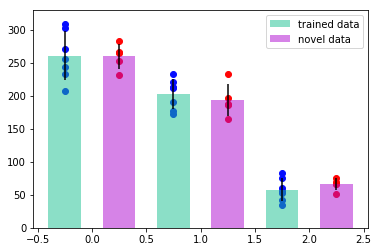

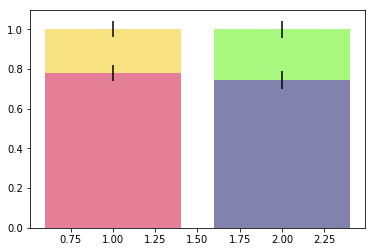

In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


explist = ['170804_02_ica_metrics.tsv',
            '171003_05_ica_metrics.tsv',
            '190408_01_ica_metrics.tsv',
            '190408_05_ica_metrics.tsv',
            '190506_05_ica_metrics.tsv',
            '190514_01_ica_metrics.tsv',
            '190603_02_ica_metrics.tsv',
            '190603_09_ica_metrics.tsv']

novellist = ['190423_01_ica_metrics.tsv',
             '190423_05_ica_metrics.tsv',
             '190506_01_ica_metrics.tsv',
             '190508_01_ica_metrics.tsv',
             '190508_05_ica_metrics.tsv']


print(len(explist))

expdir = '/home/ackmanadmin/Documents/classifier/expMetrics/'

n_components = []
n_signal = []
n_artifact = []

prop = pd.DataFrame()

for i, exp in enumerate(explist):
        data = pd.DataFrame.from_csv(expdir + exp, sep = '\t', index_col='exp_ic')
        prop.loc[exp[:9], 'n_components'] = len(data)
        prop.loc[exp[:9], 'n_signal'] = np.sum(data['signal'])
        prop.loc[exp[:9], 'n_artifact'] = np.sum(data['artifact'])

prop['perc_signal'] = prop['n_signal']/prop['n_components']
prop['perc_artifact'] = prop['n_artifact']/prop['n_components']

print(prop)

expdir = '/home/ackmanadmin/Documents/classifier/expMetrics/'

n_components = []
n_signal = []
n_artifact = []

propn = pd.DataFrame()

for i, exp in enumerate(novellist):
        data = pd.DataFrame.from_csv(expdir + exp, sep = '\t', index_col='exp_ic')
        propn.loc[exp[:9], 'n_components'] = len(data)
        propn.loc[exp[:9], 'n_signal'] = np.sum(data['signal'])
        propn.loc[exp[:9], 'n_artifact'] = np.sum(data['artifact'])
#  b'/home/ackmanadmin/Documents/classifier/p21_classifier_metrics.tsv'
propn['perc_signal'] = propn['n_signal']/propn['n_components']
propn['perc_artifact'] = propn['n_artifact']/propn['n_components']

print(propn)

b1 = plt.bar(np.arange(3)-.25, prop.mean()[:3], yerr=prop.std()[:3], alpha = 0.5, width=0.3, color = '#19C190', label = 'trained data')
plt.scatter(np.zeros(len(prop['n_components']))-.25, prop['n_components'], c='#050DFF')
plt.scatter(np.ones(len(prop['n_signal']))-.25, prop['n_signal'], c='#050DFF')
plt.scatter(np.ones(len(prop['n_artifact']))*2-.25, prop['n_artifact'], c='#050DFF')

b2 = plt.bar(np.arange(3)+.25, propn.mean()[:3], yerr=propn.std()[:3], alpha = 0.5, width=0.3, color = '#AF08D1', label = 'novel data')
plt.scatter(np.zeros(len(propn['n_components']))+.25, propn['n_components'],  c='#FF0505')
plt.scatter(np.ones(len(propn['n_signal']))+.25, propn['n_signal'],  c='#FF0505')
plt.scatter(np.ones(len(propn['n_artifact']))*2+.25, propn['n_artifact'],  c='#FF0505')

plt.legend(handles = [b1, b2])
plt.show()

plt.bar(1, prop.mean()[3], yerr=prop.std()[3], alpha = 0.5, color = "#CD0032")
plt.bar(1, prop.mean()[4], yerr=prop.std()[4], bottom = prop.mean()[3], alpha = 0.5, color = '#F2C402')
plt.bar(2, propn.mean()[3], yerr=propn.std()[3], alpha = 0.5, color = '#08065C')
plt.bar(2, propn.mean()[4], yerr=propn.std()[4], bottom = propn.mean()[3], alpha = 0.5, color = '#55F202')

plt.show()


plt.show()


plt.show()